In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [3]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    joint = (max(v)+1)*x+v
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    # shifted data
    # shift>0 => y shifted to positive side
    MIx=np.zeros(len(bitshift))
    MIv=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIjoint =np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        jj=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            jj = joint[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            jj = joint
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            jj = joint[:shift]
            rr=r[-shift:]
        pxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.append(np.unique(xx),(max(xx)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        pvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.append(np.unique(vv),(max(vv)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        pjr, xedges, yedges = np.histogram2d(jj, rr, bins=(np.append(np.unique(jj),(max(jj)+1)),np.append(np.unique(rr),(max(rr)+1))), density = True)
        px=np.sum(pxr,axis=1)
        pv=np.sum(pvr,axis=1)
        pj=np.sum(pjr,axis=1)
        pr=np.sum(pjr,axis=0)
        
        MIx[i]=np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr))/dt
        MIv[i]=np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr))/dt
        MIjoint[i]=np.nansum(pjr*np.log2(pjr/pj.reshape(-1,1)/pr))/dt
        
        PI_rX = np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr), axis = 0)
        PI_rV = np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr), axis = 0)
        Redun[i] = sum(np.minimum(PI_rX, PI_rV))/dt
    return timeshift, MIx, MIv, MIjoint, Redun

In [4]:
x = np.random.randint(2, size=30000)
y = np.array([True])
x = x.astype(bool)
for i in range(30000-1):
    y = np.append(y,(y[i] != x[i]))
x = x.astype(int)
y = y.astype(int)
z = y[1:]
y = y[:-1]
x = x[:-1]

In [5]:
#calculate information
window = [-5,5] # second
dt=1
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(y, x, z, dt, window)

Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun
Txy= Syner+Ux

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply


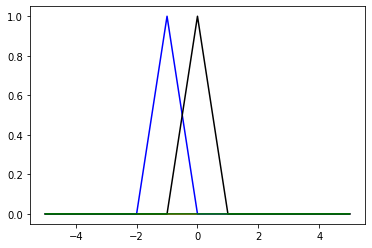

In [6]:
#plot PIs (r,x,v)
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')

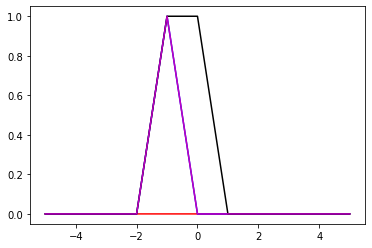

In [7]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')

In [8]:
# print('Ux =',Ux)
# print('Uv =',Uv)
# print('S =',Syner)
# print('R =',Redun)